## ForrestMapping 🍃🌲
-----


Forest species mapping supported with machine learning.

In [1]:
!pip3 -q install seaborn

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip3 -q install seaborn
!pip3 -q install cartopy
!pip3 -q install verde
!pip3 -q install tqdm
!pip3 -q install wget
!pip3 -q install contextily
# !pip3 -q install xgboost
# !pip -q install imbalanced-learn
!pip3 -q install yellowbrick

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [12]:
import pandas as pd
import geopandas as gpd
import rasterio as rio 
from rasterio.mask import mask as crop_mask
import os, wget
from collections import Counter
import numpy as np
import verde as vd
from shapely.geometry import box
# from imblearn.under_sampling import RandomUnderSampler 
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load
import enum 
import datetime as dt

from shapely import affinity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, cohen_kappa_score
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer

# from imblearn.over_sampling import SMOTE 
# from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import loguniform
# from xgboost import XGBClassifier

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [97]:
import importlib
import utils
importlib.reload(utils)

<module 'utils' from '/app/notebooks/utils.py'>

## 1. Read GeoJSON dataset

In [2]:
import geopandas as gpd

In [4]:
import utils

ModuleNotFoundError: No module named 'rasterio'

In [5]:
def get_gdf_dataset(
    gdf: gpd.GeoDataFrame, non_forest: gpd.GeoDataFrame, threshold: float = 80
):
    rename = {
        "SOS_PRC": "С",
        "OS_PRC": "ОС",
        "BER_PRC": "Б",
        "PICH_PRC": "П",
        "EL_PRC": "Е",
        "KEDR_PRC": "К",
        "LSTV_PRC": "Л",
    }

    code_class = {"С": 7, "ОС": 5, "Б": 1, "П": 6, "Е": 2, "К": 3, "Л": 4}

    target_cols = [
        "EL_PRC",
        "KEDR_PRC",
        "LSTV_PRC",
        "PICH_PRC",
        "SOS_PRC",
        "BER_PRC",
        "OS_PRC",
    ]

    mask = gdf[target_cols] > threshold
    select = gdf.loc[mask.any(axis=1)].copy()
    t = select.loc[:, target_cols].idxmax(axis=1)
    select.loc[:, "t"] = select.loc[:, target_cols].idxmax(axis=1)
    select.loc[:, "t_Клас"] = select["t"].apply(lambda x: rename[x])
    select.loc[:, "t_Class"] = select["t_Клас"].apply(lambda x: code_class[x])
    select.pop("t")
    non_forest[select.columns[:-3]] = 1
    select = pd.concat([select, non_forest[select.columns]])
    return select


In [7]:
import pandas as pd

In [8]:
# dataset with ~280 points with threshold > 80 %
# small_dataset = "../shape_data/dataset_plots.geojson"
# full dataset with ~800

full_dataset = "../shape_data/forest.geojson"
gdf = gpd.read_file(full_dataset)
non_forest=gpd.read_file('../shape_data/non_forest_settlements.geojson')

# threshold=80 -> Percent of main forest type for inventory plot
gdf = get_gdf_dataset(gdf=gdf, non_forest=non_forest,  threshold=70)
gdf = gdf.reset_index(drop=True)
gdf.loc[:, 'key'] = gdf.index


In [99]:
# gdf = gdf.explode()
# gdf

Drop small classes

In [10]:
gdf.groupby(['t_Клас']).count()

,Plot_ID,xc,yc,Plot_ID_1,HDOM_check,HGW_check,HGW,HGW11,HGW12,HGW13,...,KEDR_PRC,LSTV_PRC,PICH_PRC,SOS_PRC,BER_PRC,OS_PRC,V_PRC_ALL,geometry,t_Class,key
t_Клас,,,,,,,,,,,,,,,,,,,,,
Б,47,47,47,47,47,47,47,47,47,47,...,47,47,47,47,47,47,47,47,47,47
Е,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Л,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
ОС,81,81,81,81,81,81,81,81,81,81,...,81,81,81,81,81,81,81,81,81,81
П,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
С,106,106,106,106,106,106,106,106,106,106,...,106,106,106,106,106,106,106,106,106,106
болото,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
вырубки,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
гарь,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [11]:
# mask = gdf['t_Class'] != 6
# gdf = gdf.loc[mask]

mask = gdf['t_Class'] != 2
gdf = gdf.loc[mask]

mask = gdf['t_Class'] != 4
gdf = gdf.loc[mask]

mask = gdf['t_Class'] != 3
gdf = gdf.loc[mask]

In [13]:
gdf.groupby(['t_Клас']).count()

,Plot_ID,xc,yc,Plot_ID_1,HDOM_check,HGW_check,HGW,HGW11,HGW12,HGW13,...,KEDR_PRC,LSTV_PRC,PICH_PRC,SOS_PRC,BER_PRC,OS_PRC,V_PRC_ALL,geometry,t_Class,key
t_Клас,,,,,,,,,,,,,,,,,,,,,
Б,47,47,47,47,47,47,47,47,47,47,...,47,47,47,47,47,47,47,47,47,47
ОС,81,81,81,81,81,81,81,81,81,81,...,81,81,81,81,81,81,81,81,81,81
П,13,13,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
С,106,106,106,106,106,106,106,106,106,106,...,106,106,106,106,106,106,106,106,106,106
болото,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
вырубки,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
гарь,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
земля,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
поселения,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17


## 2. Download and read tiff file

In [102]:
dataset = utils.Dataset(path_to_tiff_file='../rasters/bands_and_terrain_texture.tiff')
# dataset.download_dataset()

gdf=dataset.procces_gdf(gdf)
bands, terrain, texture = dataset.get_dataset(gdf=gdf, scale=3.0)

Radius of forest plot: 26.92
Start preparing bands  -- Done ✅
Start preparing terrain
 -- Done ✅
Start preparing texture
 -- Done ✅


In [110]:
gdf.to_file('../shape_data/dataset.geojson', driver='GeoJSON')

In [111]:
for scale in [1, 2, 3, 5]:
    df=None
    bands, terrain, texture = dataset.get_dataset(gdf=gdf, scale=scale)
    df = pd.concat([bands.iloc[:,:-2], terrain.iloc[:,:-2], texture], axis=1)
    df.to_csv(f'../shape_data/dataset_scale_{scale}.csv')


Radius of forest plot: 8.97
Start preparing bands  -- Done ✅
Start preparing terrain
 -- Done ✅
Start preparing texture
 -- Done ✅
Radius of forest plot: 17.95
Start preparing bands  -- Done ✅
Start preparing terrain
 -- Done ✅
Start preparing texture
 -- Done ✅
Radius of forest plot: 26.92
Start preparing bands  -- Done ✅
Start preparing terrain
 -- Done ✅
Start preparing texture
 -- Done ✅
Radius of forest plot: 44.87
Start preparing bands  -- Done ✅
Start preparing terrain
 -- Done ✅
Start preparing texture
 -- Done ✅


In [113]:
df

,Unnamed: 0,B01,B02,B03,B04,B05,B06,B07,B08,B8A,...,correlation1,correlation2,dissimilarity1,dissimilarity2,energy1,energy2,homogeneity1,homogeneity2,key,class
0,2,0.11395,0.08495,0.07050,0.04700,0.0687,0.16335,0.19590,0.19260,0.21015,...,64.911243,0.000000,1.0,0.186303,0.000238,4216.082840,0.431628,1.0,0,7
1,3,0.11395,0.08520,0.06865,0.04405,0.0687,0.16335,0.19590,0.18590,0.21015,...,64.982249,0.000000,1.0,0.179370,0.000237,4225.491124,0.423522,1.0,0,7
2,4,0.11395,0.08530,0.06945,0.04700,0.0690,0.15885,0.19485,0.18310,0.20505,...,65.059172,0.000000,1.0,0.180771,0.000237,4235.449704,0.425172,1.0,0,7
3,5,0.11395,0.08600,0.07270,0.04800,0.0690,0.15885,0.19485,0.18910,0.20505,...,65.201183,0.000000,1.0,0.173418,0.000236,4254.183432,0.416435,1.0,0,7
4,6,0.11470,0.08565,0.07310,0.04805,0.0735,0.17565,0.21260,0.19415,0.22600,...,65.455621,0.000000,1.0,0.165015,0.000234,4288.260355,0.406221,1.0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27662,142,0.12140,0.14015,0.13790,0.13865,0.1307,0.21110,0.25055,0.25495,0.27140,...,80.171598,0.000169,1.0,0.053675,0.000169,6691.213018,0.231678,1.0,351,17
27663,143,0.12140,0.10050,0.09660,0.07745,0.1025,0.19485,0.23390,0.21340,0.25655,...,80.254438,0.000168,1.0,0.053745,0.000168,6703.366864,0.231829,1.0,351,17
27664,144,0.12140,0.11470,0.10880,0.10215,0.1307,0.21110,0.25055,0.25645,0.27140,...,79.668639,0.000171,1.0,0.052484,0.000171,6609.159763,0.229094,1.0,351,17
27665,145,0.12140,0.13270,0.12990,0.12485,0.1307,0.21110,0.25055,0.23595,0.27140,...,79.982249,0.000169,1.0,0.055075,0.000169,6653.544379,0.234681,1.0,351,17


In [112]:
for scale in [1, 2, 3, 5]:
    df = pd.read_csv(f'../shape_data/dataset_scale_{scale}.csv')
    print(df.shape)

(9009, 36)
(11768, 36)
(15798, 36)
(27667, 36)


In [15]:
forest_scaler = StandardScaler()

forest_scaler.fit(df.iloc[:, :-2].values)

scaled_values = forest_scaler.transform(df.iloc[:, :-2].values)

dump(forest_scaler, '../models/forest_scaler.joblib') 

['../models/forest_scaler.joblib']

In [16]:
df.iloc[:, :-2] = scaled_values
df.to_csv('settlements.csv')

## 3. Clustering

In [18]:
from utils import get_cluster_pixels, get_selection

In [19]:
correlation_threshold = 0.7

clustered_df = pd.DataFrame()

for item in df.key.unique():
    attmpt = get_cluster_pixels(df,
                                key=item,
                                correlation_threshold=correlation_threshold)
    attmpt = get_selection(attmpt)
    clustered_df = pd.concat([clustered_df, attmpt])
    print('.', end='')


...............................equal cluster........................equal cluster..........equal cluster................equal cluster.........................equal cluster..equal cluster..................................................equal cluster...................................................................................................................equal cluster................................equal cluster............equal cluster..................equal cluster......

In [20]:
print('Rows kept from initial dataset is equal to', round(len(clustered_df)/len(df)*100), '%')

Rows kept from initial dataset is equal to 64 %


## 4. Plot correlation matrix 

Goal: exclude correlated bands 

In [76]:
# Fill diagonal and upper half with NaNs
# corr = bands.corr()
# mask = np.zeros_like(corr, dtype=bool)
# mask[np.triu_indices_from(mask)] = True
# corr[mask] = np.nan
# (corr.iloc[:, :]
#  .style
#  .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
#  .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
#  .set_precision(2))


## 3. Train ML models

In [21]:
# from utils import get_metric
from utils import decodeClasses, decodeClassesLevel1

In [58]:
def get_models(class_weights: dict) -> list:
    n_jobs = 8
    return {'kNN':
        KNeighborsClassifier(
            n_jobs=n_jobs,
            algorithm="ball_tree",
            leaf_size=100,
            n_neighbors=10,
            weights="uniform",
        ),
        "RandomForest":RandomForestClassifier(
            n_jobs=n_jobs,
            random_state=42,
            criterion="gini",
            max_features="auto",
            class_weight=class_weights,
            max_depth=50,
            n_estimators=500,
            min_samples_leaf=2,
            min_samples_split=6,
        ),
        "SVC":SVC(
            random_state=42,
            gamma="scale",
            class_weight=class_weights,
            kernel="poly",
            C=1,
            degree=1,
            tol=1e-5,
            probability=True,
        ),
        "GradientBoosting":GradientBoostingClassifier(
            **{
                "n_estimators": 75,
                "min_samples_split": 47,
                "max_leaf_nodes": 52,
                "learning_rate": 0.1202,
            }
        )
           }

class ForestClasses(enum.Enum):
    Pine = 7
    Fir = 2
    Aspen = 5 
    Cedar = 3
    Larch = 4
    Birch = 1
    Silver_fir = 6
    Burnt_forest = 15
    Deforestation = 13
    Grass = 14
    Soil = 12
    Swamp = 16
    Water_body = 11
    Settlements = 17
    

def code_classes(df: pd.DataFrame)->pd.DataFrame:

    df[['forest','forest_type', 'deciduous', 'coniferous']] = -999
    # 1. Code forest
    mask_forest = df['class'] < 10
    df.loc[mask_forest, 'forest'] = 1
    df.loc[~mask_forest, 'forest'] = 0
    
    
    # 2. Code forest_type
    forest_type = {"Deciduous":0, "Coniferous":1}
    mask_coniferous = df['class'].isin([6,7])
    mask_deciduous = df['class'].isin([1,5])
    df.loc[mask_coniferous, 'forest_type'] = forest_type['Coniferous']
    df.loc[mask_deciduous, 'forest_type'] = forest_type['Deciduous']
    # 3. Code deciduous
    birch = ForestClasses.Birch.value
    df.loc[df['class'] == birch, 'deciduous'] = birch
    aspen = ForestClasses.Aspen.value
    df.loc[df['class'] == aspen, 'deciduous'] = aspen

    # 3. Code coniferous
    pine = ForestClasses.Pine.value
    df.loc[df['class'] == pine, 'coniferous'] = pine
    silver_fir = ForestClasses.Silver_fir.value
    df.loc[df['class'] == silver_fir, 'coniferous'] = silver_fir
    
    return df

def get_CNN_model():
    model = Sequential(name = 'Forest_CNN')

    model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu', input_shape =(ip_shape[0],1), name = 'Layer1'))
    model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu' , name = 'Layer2'))
    model.add(Conv1D(filters = 32, kernel_size = 3, activation ='relu' , name = 'Layer3'))

    model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer1'))
    model.add(Dropout(0.4, name = 'Dropout1'))

    model.add(Conv1D(filters = 16, kernel_size = 2, activation ='relu', name = 'Layer4'))
    model.add(Conv1D(filters = 16, kernel_size = 2, activation ='relu', name = 'Layer5'))
    model.add(Conv1D(filters = 16, kernel_size = 2, activation ='relu', name = 'Layer6'))

    model.add(MaxPooling1D(pool_size = 2, name = 'MaxPooling_Layer2'))
    model.add(Dropout(0.4, name = 'Dropout2'))

    model.add(Flatten(name = 'Flatten'))

    # model.add(Dense(25, activation='relu', name = 'DenseLayer'))

    model.add(Dense(1, activation='sigmoid', name = 'OutputLayer'))
    
def train_CNN_model(df:pd.DataFrame, gdf:gpd.GeoDataFrame,
                    target: "deciduous", model_fname:str):
    
    if target=='deciduous':
        birch = ForestClasses.Birch.value
        aspen = ForestClasses.Aspen.value
        gdf = gdf.loc[gdf['t_Class'].isin(birch, aspen)]
    if target=='coniferous':
        pine = ForestClasses.Pine.value
        silver_fir = ForestClasses.Silver_fir.value
        gdf = gdf.loc[gdf['t_Class'].isin(pine, silver_fir)]
    X_train, X_test, y_train, y_test = train_test_split(gdf,
                                                    gdf['class_name'],
                                                    test_size=test_size)
    train = df.loc[df['key'].isin(X_train['key'])]
    test = df.loc[df['key'].isin(X_test['key'])]
    remove_cols = ['key', 'class', 'forest', 'forest_type',
       'deciduous', 'coniferous']
    X_train = train.drop(columns=remove_cols).astype('float')
    X_test = test.drop(columns=remove_cols).astype('float')
    y_train = train[target].astype(int)
    y_test = test[target].astype(int)
                  
    assert set(y_test) == set(y_train), 'Houston, we have problems'                  

    ip_shape = X_train.values[1].shape

    n_outputs = 1

    X_train = X_train.values.reshape(-1, 16, 1) # TO-DO Replace 16 to shape of features
    X_test = X_test.values.reshape(-1, 16, 1)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['f1'])

    early_stop = EarlyStopping(monitor = 'val_loss',
                                mode = 'min',
                                min_delta = 0,
                                patience = 10,
                                restore_best_weights = True)

    checkpoint = ModelCheckpoint(filepath = f'{model_fname}.h5', 
                                 monitor = 'val_loss', 
                                 mode ='min', 
                                 save_best_only = True)


    hist = model.fit(X_train, 
                           y_train.values, 
                           epochs = 100, 
                           batch_size = 128 , 
                           validation_data = (X_test, y_test.values), 
                           callbacks=[early_stop,
                                      checkpoint,
                                      tensorboard])
    return model
#     loss, acc = model.evaluate(X_test, y_test)

def train_ml_model(df:pd.DataFrame, gdf:gpd.GeoDataFrame, target: "forest",
                   test_size: float=0.25):
    if target not in ['forest', 'forest_type']:
        raise KeyError('works only for target forest, forest_type')
    if target=='forest_type':
        gdf = gdf.loc[gdf['t_Class']<10]

    X_train, X_test, y_train, y_test = train_test_split(gdf,
                                                    gdf['class_name'],
                                                    test_size=test_size)
    train = df.loc[df['key'].isin(X_train['key'])]
    test = df.loc[df['key'].isin(X_test['key'])]
    remove_cols = ['key', 'class', 'forest', 'forest_type',
       'deciduous', 'coniferous']
    X_train = train.drop(columns=remove_cols).astype('float')
    X_test = test.drop(columns=remove_cols).astype('float')
    y_train = train[target].astype(int)
    y_test = test[target].astype(int)
    
    class_weights_vals = compute_class_weight(class_weight = "balanced", 
                                          classes= np.unique(y_train),
                                          y= y_train)
    class_weights = {x:y for x,y in zip(np.unique(y_train), 
                                    class_weights_vals)}
                  
    models = get_models(class_weights=class_weights)
    container = {}
    for name_model, model in models.items():
        scores=cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
        print(name_model, scores)
        model.fit(X_train, y_train)
        f1 = f1_score(y_test, model.predict(X_test))
        kappa = cohen_kappa_score(y_test, model.predict(X_test))
        container[name_model]={'f1':f1, "kappa":kappa, "model":model }
    return container


Clustered input 

In [31]:
# print("All bands: ", len(clustered_df.columns))
# corr_matrix = bands.iloc[:, :-2].corr().abs()
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
# to_drop = [column for column in upper.columns if any(upper[column] > 0.97)]
# # Drop features 
# input_df = clustered_df.drop(to_drop, axis=1)
# print("Non correlated bands: ", len(input_df.columns))

Non Clustered input 

In [32]:
# print("All bands: ", len(clustered_df.columns))
# corr_matrix = bands.iloc[:, :-2].corr().abs()
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
# to_drop = [column for column in upper.columns if any(upper[column] > 0.97)]
# # Drop features 
# input_df = pd.concat([bands.iloc[:,:-2], terrain], axis=1).drop(to_drop, axis=1)
# print("Non correlated bands: ", len(input_df.columns))

## Задачи 🐝


1. Классифакия - Deciduous и Coniferous
2. Классификация - Сосна и Пихта 
3. Классификация - Береза и Осина 

### 3. Классифакия - Hierarchical

In [24]:
df = clustered_df.drop(columns='clusters').copy()

In [25]:
df.head()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,EVI,MSAVI,NDRE,FCI,aspect,slope,wetnessindex,sink,key,class
0,-0.581056,-0.539191,-0.472659,-0.738886,-0.723726,-0.318696,-0.314211,-0.215627,-0.323721,-0.233667,...,0.155033,0.118273,0.608221,-0.540575,0.424493,-0.321883,-0.832842,-1.35656,0,7
1,-0.581056,-0.724222,-0.555035,-0.801544,-0.723726,-0.318696,-0.314211,-0.310268,-0.323721,-0.233667,...,0.087890,0.046574,0.530691,-0.633190,0.424493,-0.321883,-0.832842,-1.35656,0,7
2,-0.581056,-0.651070,-0.658900,-0.842408,-0.684496,-0.294673,-0.302268,-0.332638,-0.271211,-0.233667,...,0.083881,0.041318,0.474613,-0.673162,0.424493,-0.321883,-0.832842,-1.35656,0,7
3,-0.581056,-0.586524,-0.623084,-0.785198,-0.684496,-0.294673,-0.302268,-0.467717,-0.271211,-0.233667,...,-0.081025,-0.128227,0.356215,-0.705082,0.424493,-0.321883,-0.832842,-1.35656,0,7
4,-0.492653,-0.620949,-0.458333,-0.665330,-0.568871,-0.057714,-0.039531,-0.220789,-0.092521,-0.147997,...,0.116162,0.079593,0.460737,-0.492648,0.424493,-0.321883,-0.832842,-1.35656,0,7


Decode classes (one-hot encoding)

In [39]:
df_coded = code_classes(df)

Train Model for forest classification

### 3.1 Классифакия -Forest / Non-forest

In [41]:
# Log model name and f1 for cross validation
results = train_ml_model(df=df_coded, gdf=gdf, target='forest')


[1.         0.95774648 0.99089727 0.97961783 0.97718631]
[1.         0.97286565 1.         0.98086735 0.97609562]
[0.99805321 0.96584059 0.99935191 0.98717949 1.        ]
[0.99935191 0.96442688 1.         0.97712834 0.99611399]


In [44]:
# metric results
pd.DataFrame(results).T

,f1,kappa,model
kNN,0.995871,0.985597,"KNeighborsClassifier(algorithm='ball_tree', le..."
RandomForest,0.993183,0.975641,"(DecisionTreeClassifier(max_depth=50, max_feat..."
SVC,0.997605,0.991524,"SVC(C=1, class_weight={0: 0.9580760095011877, ..."
GradientBoosting,0.994536,0.980574,([DecisionTreeRegressor(criterion='friedman_ms...


Save model

In [47]:
dump(results['SVC']['model'], '../models/forest_model_svc.joblib')

['../models/forest_model_svc.joblib']

### 3.2 Классифакия - Forest type (Deciduous and Coniferous)

In [55]:
results_type = train_ml_model(df=df_coded, gdf=gdf, target='forest_type')

kNN [0.85033113 0.73096447 0.73181325 0.8267009  0.72289157]
RandomForest [0.8772846  0.73613767 0.71663244 0.86936937 0.8101983 ]
SVC [0.86197917 0.81404959 0.62321792 0.9187935  0.77400295]
GradientBoosting [0.87287025 0.73744076 0.70354906 0.85550459 0.7818448 ]


In [56]:
# metric results
pd.DataFrame(results_type).T

,f1,kappa,model
kNN,0.71821,0.54608,"KNeighborsClassifier(algorithm='ball_tree', le..."
RandomForest,0.825271,0.713033,"(DecisionTreeClassifier(max_depth=50, max_feat..."
SVC,0.819512,0.701333,"SVC(C=1, class_weight={0: 1.0352729145211124, ..."
GradientBoosting,0.782347,0.646176,([DecisionTreeRegressor(criterion='friedman_ms...


In [57]:
dump(results['SVC']['model'], '../models/forest_type_model_rf.joblib')

['../models/forest_type_model_rf.joblib']

### 3.3 Классифакия - Deciduous 

In [60]:
!pip3 install tensorflow

     |████████████████████████████████| 585.9 MB 9.3 kB/s eta 0:00:017     |██████████████████▊             | 343.4 MB 5.0 MB/s eta 0:00:49     |███████████████████████▋        | 432.3 MB 8.0 MB/s eta 0:00:20
     |████████████████████████████████| 440 kB 9.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 9.9 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 12.7 MB/s eta 0:00:01
     |████████████████████████████████| 304 kB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 5.1 MB 11.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 13.5 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 4.6 MB/s  eta 0:00:01
     |████████████████████████████████| 1.3 MB 9.4 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 57 kB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 17.1 MB 7.

  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.2
    Uninstalling numpy-1.21.2:
      Successfully uninstalled numpy-1.21.2


In [62]:
!pip install numpy --upgrade

     |████████████████████████████████| 17.3 MB 6.5 MB/s eta 0:00:01
ERROR: tensorflow 2.12.0 has requirement numpy<1.24,>=1.22, but you'll have numpy 1.24.3 which is incompatible.
ERROR: scipy 1.7.1 has requirement numpy<1.23.0,>=1.16.5, but you'll have numpy 1.24.3 which is incompatible.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from tqdm import tqdm
from numpy.random import seed
from time import time


2023-06-03 19:36:08.189624: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-03 19:36:08.250483: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-03 19:36:08.251500: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-03 19:36:10.211135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
results_type = train_ml_model(df=df_coded, gdf=gdf, target='forest_type')

### 3.4 Классифакия -  Coniferous

In [130]:
some_model = base_classfiers[-1]
y_predict = some_model.predict(X_test)

accuracy_score = metrics.accuracy_score(y_test, y_predict)

metrics.f1_score(y_predict, y_test, average='weighted')

0.7531318817909575

In [133]:
df_i = pd.DataFrame(metrics.classification_report(y_test, y_predict, digits=2, output_dict=True)).T
df_i['model'] = some_model.__class__.__name__

In [134]:


forest_type = {"Deciduous":0, "Coniferous":1}df_i.index

df_i.index = pd.Series(df_i.index).apply(lambda x: decodeClassesLevel1(x))

,precision,recall,f1-score,support,model
0,0.743787,0.751515,0.747631,1155.000000,GradientBoostingClassifier
1,0.762220,0.754717,0.758450,1219.000000,GradientBoostingClassifier
accuracy,0.753159,0.753159,0.753159,0.753159,GradientBoostingClassifier
macro avg,0.753004,0.753116,0.753041,2374.000000,GradientBoostingClassifier
weighted avg,0.753252,0.753159,0.753187,2374.000000,GradientBoostingClassifier


In [ ]:
df = input_df.copy()
df[dataset.terrain_cols]= df[dataset.terrain_cols].astype(float)
df.iloc[:, :-3] = StandardScaler().fit_transform(df.iloc[:, :-3])

# Resampling - to balance classes
# df = resample_forest(df)
only_forest = True
if only_forest:
    forest_gdf = gdf.loc[gdf['t_Class']<8]
else:
    forest_gdf = gdf.loc[gdf['t_Class']<30]

bunary_test = True
if bunary_test:
    forest_gdf = gdf.loc[gdf['t_Class'].isin([1,5])]
X_train, X_test, y_train, y_test = train_test_split(forest_gdf,
                                                    forest_gdf['class_name'],
                                                    test_size=0.3)

train = df.loc[df['key'].isin(X_train['key'])]
test = df.loc[df['key'].isin(X_test['key'])]
X_train = train.drop(columns=['key','class']).astype('float')
X_test = test.drop(columns=['key','class']).astype('float')
y_train = train['class'].astype(int)
y_test = test['class'].astype(int)

# class weights
class_weights_vals = compute_class_weight(class_weight = "balanced", 
                                          classes= np.unique(y_train),
                                          y= y_train)
class_weights = {x:y for x,y in zip(np.unique(y_train), 
                                    class_weights_vals)}

# models
n_jobs = 8
name_classfiers = ['KNeighborsClassifier',
                   'DecisionTreeClassifier',
                   'RandomForest',
                   'ExtraTreesClassifier',
#                    'RidgeClassifier',
                   'LogisticRegression',
                   'SVC',
                   'GradientBoostingClassifier'
                   ]
base_classfiers = get_models(class_weights=class_weights)
for i in range(len(base_classfiers)):
    base_classfiers[i].fit(X_train, y_train)
    print('Done: '+name_classfiers[i])

# df_score_group, df_score_class_dict = get_metric(base_classfiers=base_classfiers,
#                                                  y_test=y_test, 
#                                                 X_test=X_test)


In [93]:
some_model = base_classfiers[-1]

In [85]:
some_model = base_classfiers[-1]
y_predict = some_model.predict(X_test)

accuracy_score = metrics.accuracy_score(y_test, y_predict)

metrics.f1_score(y_predict, y_test, average='weighted')

In [98]:
accuracy_score = metrics.accuracy_score(y_test, y_predict, )

In [107]:
metrics.f1_score(y_predict, y_test, average='weighted')

0.6161113621583282

In [100]:
accuracy_score

0.6110678098207326

In [136]:
df_i = pd.DataFrame(metrics.classification_report(y_test, y_predict, digits=2, output_dict=True)).T
df_i['model'] = some_model.__class__.__name__

df_i.index = pd.Series(df_i.index).apply(lambda x: decodeClassesLevel1(x))

KeyError: 0

In [137]:
df_i

,precision,recall,f1-score,support,model
0,0.743787,0.751515,0.747631,1155.000000,GradientBoostingClassifier
1,0.762220,0.754717,0.758450,1219.000000,GradientBoostingClassifier
accuracy,0.753159,0.753159,0.753159,0.753159,GradientBoostingClassifier
macro avg,0.753004,0.753116,0.753041,2374.000000,GradientBoostingClassifier
weighted avg,0.753252,0.753159,0.753187,2374.000000,GradientBoostingClassifier


In [ ]:
def get_metric(base_classfiers: list, y_test: np.ndarray, X_test: np.ndarray):
    score_classfiers_accuracy_score = []
    score_classfiers_roc_auc_score = []
    score_classfiers_f1_score = []
    df_score_class_dict = {}
    df_score_class_list = []

    name_classifiers = [
        "KNeighborsClassifier",
        "DecisionTreeClassifier",
        "RandomForest",
        "ExtraTreesClassifier",
        "RidgeClassifier",
        "LogisticRegression",
        "SVC",
        "GradientBoostingClassifier",
    ]
    for i in range(len(base_classfiers)):
        y_predict = base_classfiers[i].predict(X_test)
        score_classfiers_accuracy_score.append(accuracy_score(y_test, y_predict))
        if name_classifiers[i] != "RidgeClassifier":
            score_classfiers_roc_auc_score.append(
                roc_auc_score(
                    y_test, base_classfiers[i].predict_proba(X_test), multi_class="ovr"
                )
            )
#         else:
#             ridge_predict = []
#             for k in range(len(X_test)):
#                 d = base_classfiers[i].decision_function(X_test)[k]
#                 probs = np.exp(d) / np.sum(np.exp(d))
#                 ridge_predict.append(probs)
#             ridge_predict = np.array(ridge_predict)
#             score_classfiers_roc_auc_score.append(
#                 roc_auc_score(y_test, ridge_predict, multi_class="ovr")
#             )

        score_classfiers_f1_score.append(
            f1_score(y_test, y_predict, average="weighted")
        )
        df_i = pd.DataFrame(
            metrics.classification_report(y_test, y_predict, digits=2, output_dict=True)
        ).transpose()
        arrays_col = [
            [
                name_classifiers[i],
                name_classifiers[i],
                name_classifiers[i],
                name_classifiers[i],
            ],
            list(df_i.columns),
        ]
        df_i.columns = pd.MultiIndex.from_tuples(list(zip(*arrays_col)))
        df_score_class_list.append(df_i)
        df_score_class_dict[name_classifiers[i]] = df_i

    df_score_class = df_score_class_list[0]
    for i in range(1, len(df_score_class_list)):
        df_score_class = df_score_class.join(df_score_class_list[i])
    df_score_class_index = list(df_score_class.index)

    df_score_group = pd.DataFrame(
        columns=["Model", "Accuracy score", "ROC AUC score", "f1 score"]
    )
    df_score_group["Model"] = name_classifiers
    df_score_group["Accuracy score"] = score_classfiers_accuracy_score
    df_score_group["ROC AUC score"] = score_classfiers_roc_auc_score
    df_score_group["f1 score"] = score_classfiers_f1_score

    return df_score_group, df_score_class_dict


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


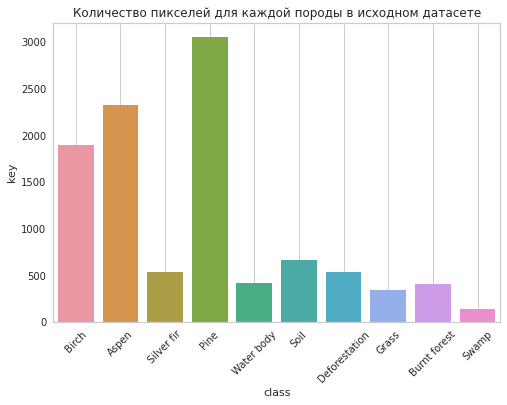

In [33]:
dict_normal_names={7: "Pine", 
        2:"Fir", 
        5:"Aspen",
        3:"Cedar",
        4:"Larch",
        1:"Birch",
        6:"Silver fir",
        15:"Burnt forest", 
        13:'Deforestation', 
        14:'Grass',
        12:'Soil', 
        16:'Swamp', 
        11:'Water body'}
pixels_per_class = df.groupby('class', as_index=False).count()
pixels_per_class['class'] = pixels_per_class['class'].apply(lambda x: dict_normal_names[x])
sns.barplot(data=pixels_per_class, x='class', y='key')
plt.grid()
plt.title('Количество пикселей для каждой породы в исходном датасете')
plt.xticks(rotation=45)
plt.show()

In [34]:
df_score_group

,Model,Accuracy score,ROC AUC score,f1 score
0,KNeighborsClassifier,0.467430,0.685776,0.466750
1,DecisionTreeClassifier,0.478873,0.656654,0.480315
2,RandomForest,0.576585,0.807701,0.574474
3,ExtraTreesClassifier,0.521127,0.794198,0.519066
4,LogisticRegression,0.491637,0.804411,0.486293
5,SVC,0.444102,0.781118,0.436285
6,GradientBoostingClassifier,0.546215,0.789592,0.542109


In [43]:
df_score_class_dict['RandomForest']

RandomForest                                 
                precision    recall  f1-score      support
Birch            0.489726  0.509804  0.499563   561.000000
Aspen            0.522692  0.461964  0.490455   723.000000
Silver fir       0.952381  0.559441  0.704846   143.000000
Pine             0.632124  0.721893  0.674033   845.000000
accuracy         0.576585  0.576585  0.576585     0.576585
macro avg        0.649231  0.563276  0.592224  2272.000000
weighted avg     0.582297  0.576585  0.574474  2272.000000

In [35]:
scores_model = df_score_class_dict['RandomForest']
scores_model.index = pd.Series(scores_model.index).apply(lambda x: decodeClassesLevel1(x))
scores_model

RandomForest                                 
                precision    recall  f1-score      support
Birch            0.489726  0.509804  0.499563   561.000000
Aspen            0.522692  0.461964  0.490455   723.000000
Silver fir       0.952381  0.559441  0.704846   143.000000
Pine             0.632124  0.721893  0.674033   845.000000
accuracy         0.576585  0.576585  0.576585     0.576585
macro avg        0.649231  0.563276  0.592224  2272.000000
weighted avg     0.582297  0.576585  0.574474  2272.000000

In [37]:
scores_model = df_score_class_dict['RandomForest']
scores_model.index = pd.Series(scores_model.index).apply(lambda x: decodeClassesLevel1(x))
scores_model

RandomForest                                 
                precision    recall  f1-score      support
Birch            0.489726  0.509804  0.499563   561.000000
Aspen            0.522692  0.461964  0.490455   723.000000
Silver fir       0.952381  0.559441  0.704846   143.000000
Pine             0.632124  0.721893  0.674033   845.000000
accuracy         0.576585  0.576585  0.576585     0.576585
macro avg        0.649231  0.563276  0.592224  2272.000000
weighted avg     0.582297  0.576585  0.574474  2272.000000

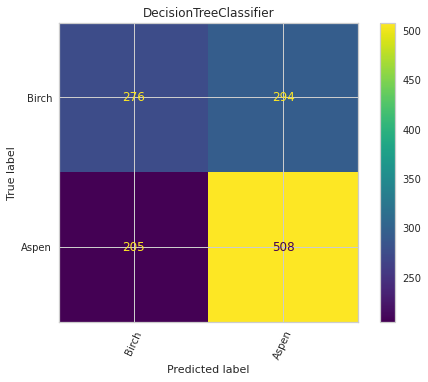

In [97]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
dict_normal_names={7: "Pine", 
        2:"Fir", 
        5:"Aspen",
        3:"Cedar",
        4:"Larch",
        1:"Birch",
        6:"Silver fir",
        15:"Burnt forest", 
        13:'Deforestation', 
        14:'Grass',
        12:'Soil', 
        16:'Swamp', 
        11:'Water body'}

clf = base_classfiers[2]
predictions = clf.predict(X_test)
names = [dict_normal_names[value] for value in clf.classes_]
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=names)
disp.plot()
plt.title(name_classfiers[-6])
plt.xticks(rotation=65)
plt.show()

## 3. Кластеризация

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3783 samples in 0.001s...
[t-SNE] Computed neighbors for 3783 samples in 0.327s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3783
[t-SNE] Computed conditional probabilities for sample 2000 / 3783
[t-SNE] Computed conditional probabilities for sample 3000 / 3783
[t-SNE] Computed conditional probabilities for sample 3783 / 3783
[t-SNE] Mean sigma: 0.043459
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.820465
[t-SNE] KL divergence after 1000 iterations: 0.590038


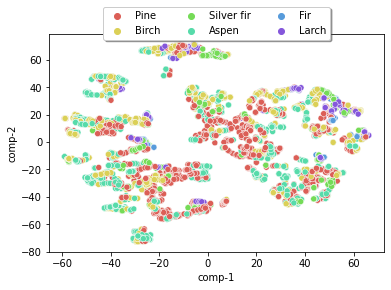

In [67]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123)
df = pd.concat([bands.iloc[:, :-2], terrain], axis=1)
df = df.copy()
df[['aspect','slope','wetnessindex','sink']] = df[['aspect','slope','wetnessindex','sink']].astype(float)

forest = df["class"] < 8
df = df.loc[forest]

X = df.iloc[:, :-2]
z = tsne.fit_transform(X)

df_plot = pd.DataFrame(data=df.iloc[:, -1].values, columns=['y'])
# df_plot["y"] = df.iloc[:, :-1]
df_plot['y'] = df_plot['y'].apply(lambda x: dict_normal_names[x])
df_plot["comp-1"] = z[:,0]
df_plot["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df_plot.y.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df_plot).set(title="Forest data T-SNE projection")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, fancybox=True, shadow=True)
plt.show()

# END

## another exp

In [85]:
forest_gdf = gdf.loc[gdf['t_Class']<8]
X_train, X_test, y_train, y_test = train_test_split(forest_gdf, forest_gdf['class_name'], test_size=0.3)

train = df_resampled.loc[df_resampled['key'].isin(X_train['key'])]

test = df_resampled.loc[df_resampled['key'].isin(X_test['key'])]


X_train = train.drop(columns=['key','class']).astype('float')
X_test = test.drop(columns=['key','class']).astype('float')
y_train = train['class'].astype(int)
y_test = test['class'].astype(int)

In [109]:
from imblearn.over_sampling import SMOTE

In [131]:
rus = SMOTE()
X_res, y_res = rus.fit_resample(df_resampled.iloc[:, :-1], df_resampled.iloc[:, -1].astype(int))
sub_df_resampled= pd.DataFrame(X_res, columns=df.columns[:-1])
sub_df_resampled.loc[:, 'class'] = y_res

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
pl = Pipeline([('scaler', StandardScaler()),
               ('pca', PCA()),
               ('clf', GradientBoostingClassifier())])


X_train = train.drop(columns=['key','class']).astype('float')
X_test = test.drop(columns=['key','class']).astype('float')
y_train = train['class'].astype(int)
y_test = test['class'].astype(int)

y_test=codeClasses(y_test)
y_train=codeClasses(y_train)
# cv = CrossValidatorWrapper(KFold())
gridsearch = GridSearchCV(pl, scoring='balanced_accuracy',
                    param_grid={
                      "scaler__with_std":[True,False],
                      "pca__n_components": [1, 2, 3]
                      }, n_jobs=8)

gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('clf', GradientBoostingClassifier())]),
             n_jobs=8,
             param_grid={'pca__n_components': [1, 2, 3],
                         'scaler__with_std': [True, False]},
             scoring='balanced_accuracy')

In [65]:
results = gridsearch.cv_results_

In [514]:
X_train = train.drop(columns=['key','class']).astype('float')
X_test = test.drop(columns=['key','class']).astype('float')
y_train = train['class'].astype(int)
y_test = test['class'].astype(int)

y_test=codeClasses(y_test)
y_train=codeClasses(y_train)

In [2]:
seed = 7
models = []
models.append(('SVC', SVC(verbose=True)))
models.append(('RandomForest', RandomForestClassifier(verbose=1, n)))
models.append(('GB', GradientBoostingClassifier()))
models.append(('RidgeClassifier', RidgeClassifier()))

results = []
names = []
# scoring = {"OA":"balanced_accuracy", "f1_macro":'f1_macro'}
scoring= 'f1_macro'
for name, model in models:
    kfold = model_selection.KFold(n_splits=5)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
# plt.savefig('../plots/models_comparison.png', dpi=150)
plt.show()


In [1]:
## two-metrics scoring
scoring = {"OA":"balanced_accuracy", "f1_macro":'f1_macro'}

param_grid = {
    "n_estimators": range(5, 100, 10),
    "max_leaf_nodes": range(2, 100, 10),
    "min_samples_split": range(2, 50, 5),
    "learning_rate": loguniform.rvs(0.01, 1, size=10),
}

gs = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42, verbose=0),
    n_iter=100,
    param_distributions=param_grid,
    scoring=scoring,
    cv=5,
    refit="f1_macro",
    n_jobs=8,
    return_train_score=True,
    verbose=10
)
gs.fit(X_train, y_train)
results = gs.cv_results_

In [298]:
OA = results['mean_test_OA']
f1_macro = results['mean_test_f1_macro']

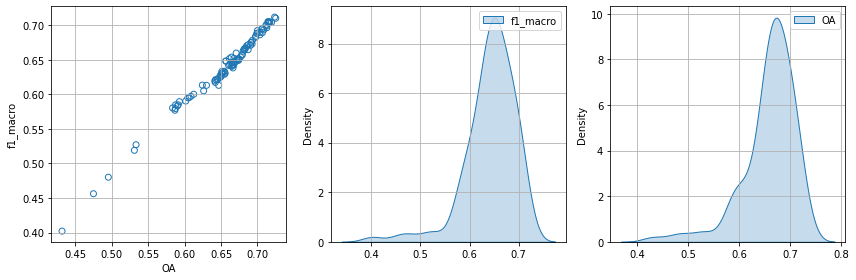

In [299]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), tight_layout=True)
ax1.scatter(OA, f1_macro, edgecolors=sns.color_palette()[0], facecolors='none')
ax1.grid()
# ax1.set_ylim(0,1)
# ax1.set_xlim(0,10)
ax1.set_ylabel("f1_macro")
ax1.set_xlabel("OA")
# ax2.scatter(mape_normalized, r2_normalize)
sns.kdeplot(f1_macro, fill=True, label="f1_macro", ax=ax2)
ax2.grid()
ax2.legend()
sns.kdeplot(OA, fill=True, label="OA", ax=ax3)
ax3.grid()
ax3.legend()
# ax2.set_ylabel("$R^2$")
# ax2.set_xlabel("$MAPE$")
# plt.savefig('../plots/two_metrics_plots.png', dpi=300)

## 6. Color geotiff

In [146]:
fname = '/mnt/bulky2/mgasanov/CARBON/Sentinell2/ForestSentinell2/summer_2020.tiff'
with rio.open(fname) as src:
    bands_row= src.read()

In [149]:
shape_row = bands_row.shape

In [152]:
dates_images_2020 = ["2020-07-03", "2020-07-05", "2020-07-13",
                     "2020-08-04", "2020-08-09", "2020-08-12", "2020-08-17"]

def get_2020_cols():
    col_names = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12","CLM"]
    all_cols = []
    i = 0
    for date in sorted(dates_images_2020):
        for col in col_names:
            
            all_cols.append(date+'_'+col)
    return all_cols

cols_2020 = get_2020_cols()

x = bands_row[:-4, ...].reshape(len(cols_2020), bands_row.shape[1]*bands_row.shape[2])

In [177]:
for i in range(x.shape[1]//100000 + 1):
    select = x[:, i*100000:(i+1)*100000]
    if (i+1)*100000 > x.shape[1]:
        select = x[:, i*100000:x.shape[1]]
    break

In [184]:
df_indices_field = pd.DataFrame(select.T, columns=cols_2020)

In [185]:
def prepare_SVI(df:pd.DataFrame)->pd.DataFrame:
    for date in ["2020-07-03", "2020-07-05", "2020-07-13",
                     "2020-08-04", "2020-08-09", "2020-08-12", "2020-08-17"]:
        print(date)
        df = dataset.get_ndvi(df, date)
        df = dataset.generate_NDRE(df, date)
        df = dataset.evi(df, date)
        df = dataset.generate_MSAVI(df, date)

    return df
df_indices_field = prepare_SVI(df_indices_field)

2020-07-03
2020-07-05
2020-07-13
2020-08-04
2020-08-09
2020-08-12
2020-08-17


In [ ]:
dates_images_2020 = ["2020-07-03", "2020-07-05", "2020-07-13",
                     "2020-08-04", "2020-08-09", "2020-08-12", "2020-08-17"]

def get_2020_cols():
    col_names = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12","CLM"]
    all_cols = []
    i = 0
    for date in sorted(dates_images_2020):
        for col in col_names:
            
            all_cols.append(date+'_'+col)
    return all_cols

cols_2020 = get_2020_cols()


# shape = box(*gdf.total_bounds)
fname = '/mnt/bulky2/mgasanov/CARBON/Sentinell2/ForestSentinell2/summer_2020.tiff'
with rio.open(fname) as src:
    bands_row= src.read()
x = bands_row[:-4, ...].reshape(len(cols_2020), bands_row.shape[1]*bands_row.shape[2])


df_indices_field = pd.DataFrame(x.T[::100, :], columns=cols_2020)


def prepare_SVI(df:pd.DataFrame)->pd.DataFrame:
    for date in ["2020-07-03", "2020-07-05", "2020-07-13",
                     "2020-08-04", "2020-08-09", "2020-08-12", "2020-08-17"]:
        print(date)
        df = dataset.get_ndvi(df, date)
        df = dataset.generate_NDRE(df, date)
        df = dataset.evi(df, date)
        df = dataset.generate_MSAVI(df, date)

    return df

# slices =  
mean_X = np.ones(shape=(13, x.shape[1]))
for y in range(14):
    print(y)
    channels = []
    for i in range(len(dates_images_2020)):
        channels.append(y-1 + i * 13)
    mean_channel = x[channels, ...].mean(axis=0)
    mean_X[y] = mean_channel

## 2. EDA

In [3]:
# # Fill diagonal and upper half with NaNs
# corr = non_forest.corr()
# mask = np.zeros_like(corr, dtype=bool)
# mask[np.triu_indices_from(mask)] = True
# corr[mask] = np.nan
# (corr.iloc[::3, ::2]
#  .style
#  .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
#  .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
#  .set_precision(2))

In [353]:
corr_matrix = non_forest.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop features 
non_forest.drop(to_drop, axis=1, inplace=True)

In [1]:
# # Fill diagonal and upper half with NaNs
# corr = non_forest.corr()
# mask = np.zeros_like(corr, dtype=bool)
# mask[np.triu_indices_from(mask)] = True
# corr[mask] = np.nan
# (corr.iloc[:, :]
#  .style
#  .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
#  .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
#  .set_precision(2))

## 3. Plotting


In [349]:

def plot_RGB_file(fname: str): 
    img = rio.open(fname)

    red = img.read(4)
    green = img.read(3)
    blue = img.read(2)

    red_b=brighten(red)
    blue_b=brighten(blue)
    green_b=brighten(green)

    red_bn = normalize(red_b)
    green_bn = normalize(green_b)
    blue_bn = normalize(blue_b)

    rgb_composite_bn= np.dstack((red_bn, green_bn, blue_bn))
    return rgb_composite_bn

def plot_RGB_matrix(img)->None: 
    red = img[4, ...]
    green = img[3, ...]
    blue = img[2, ...]
    red_b=brighten(red)
    blue_b=brighten(blue)
    green_b=brighten(green)

    red_bn = normalize(red_b)
    green_bn = normalize(green_b)
    blue_bn = normalize(blue_b)

    rgb_composite_bn= np.dstack((red_bn, green_bn, blue_bn))
    plt.imshow(rgb_composite_bn)

In [ ]:
path='/mnt/bulky2/mgasanov/CARBON/Sentinell2/ForestSentinell2/'
list_of_geotiff = [tiff for tiff in os.listdir(path) if 'tiff' in tiff]
mask = (df_indices_field['date'].dt.month>6) & (df_indices_field['date'].dt.month<9)
dates_images = df_indices_field.loc[mask, 'date'].unique()
dates_images = [str(image)[:10] for image in dates_images]

In [148]:
src = rio.open(path_to_tiff_file)

In [100]:
dataset = Dataset()
src = rio.open(dataset.path_to_tiff_file)
X = src.read()

In [20]:
s2 = rio.open("/mnt/bulky2/mgasanov/CARBON/Sentinell2/ForestSentinell2/2019-06-19.tiff")
s2.read(2).shape

(13, 3300, 2966)

In [153]:
def normalize(X):
    X = X/10000
    X = np.clip(X, 0, 0.3)
    return X

In [162]:
X = normalize(124)

In [220]:
for x in sorted(dates_images):
    print(x+'.tiff ', end='')

2019-07-01.tiff 2019-07-04.tiff 2019-08-03.tiff 2019-08-05.tiff 2019-08-08.tiff 2019-08-15.tiff 2019-08-30.tiff 2020-07-03.tiff 2020-07-05.tiff 2020-07-13.tiff 2020-08-04.tiff 2020-08-09.tiff 2020-08-12.tiff 2020-08-17.tiff 

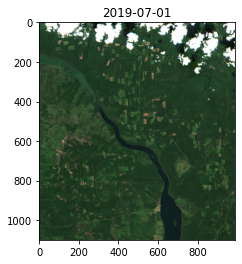

In [147]:
for tiff_file in sorted(dates_images):
    path_to_tiff_file = os.path.join(path, tiff_file+'.tiff')
    print()
    rgb_composite_bn = plot_RGB_file(path_to_tiff_file)
    plt.imshow(rgb_composite_bn[::3, ::3, :])
    plt.title(tiff_file.split('.')[0])
    plt.show()
    break

In [114]:
shape = gdf.iloc[0,-2]

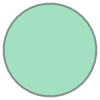

In [115]:
shape

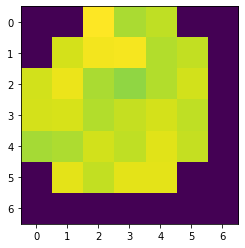

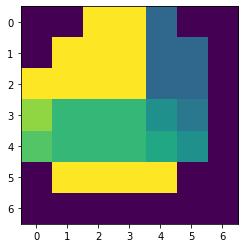

In [136]:


shape = gdf.iloc[-2,-2]


with rio.open(dataset.path_to_tiff_file) as src:
    out_image, out_transform = crop_mask(src, [shape], crop=True, nodata=0) # SUPER KEK - [shape] works, shape - doesn't 
    out_meta = src.meta 
#     x = out_image[:12, ...].reshape(12, out_image.shape[1]*out_image.shape[2])
# _df = pd.DataFrame(x.T, columns=col_names[:-1])
#     df
# plt.imshow(out_image[3,...])

plt.imshow(out_image[1,...])
plt.show()

plt.imshow(out_image[-4,...])
plt.show()

In [137]:
s2 = out_image[2,...]

t1 = out_image[-2,...]

sub_m = np.where(s2>0, t1, -1)

In [138]:
s2.shape

(7, 7)

In [145]:
sub_m = np.where(s2>0, t1, -1)

array([[-1, -1,  0,  0,  8, -1, -1],
       [-1,  0,  0,  0,  8,  8, -1],
       [ 8,  0,  0,  0,  8,  8, -1],
       [ 8,  8,  8,  8,  8,  8, -1],
       [ 8,  8,  8,  8,  8,  9, -1],
       [-1,  0,  0,  0,  0, -1, -1],
       [-1, -1, -1, -1, -1, -1, -1]], dtype=int32)

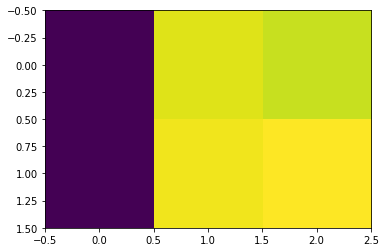

In [119]:
plt.imshow(out_image[1,...])

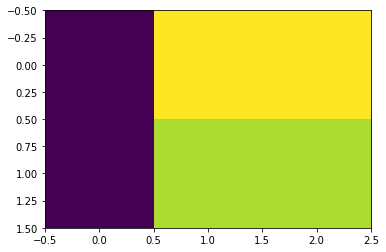

In [123]:
plt.imshow(out_image[-2,...])

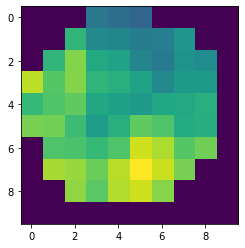

In [73]:
col_names = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12","CLM"]
path='/Users/mikhailgasanov/Yandex.Disk.localized/STRIP/Bratsk/Sentinel2_2019_10_meters/'
year = 2019
list_of_geotiff = [tiff for tiff in os.listdir(path) if (str('-') in tiff) and ('tiff' in tiff)]

df_indices_field = pd.DataFrame(columns = ['date',  *col_names, "NDVI"])

dates_of_images = []



for tiff_file in sorted(list_of_geotiff):
    path_to_tiff_file = os.path.join(path, tiff_file)
    with rio.open(path_to_tiff_file) as src:
        out_image, out_transform = crop_mask(src, [shape], crop=True) # SUPER KEK - [shape] works, shape - doesn't
        out_meta = src.meta 
        x = out_image[:12, ...].reshape(12, out_image.shape[1]*out_image.shape[2])
    _df = pd.DataFrame(x.T, columns=col_names[:-1])
#     df
plt.imshow(out_image[3,...])

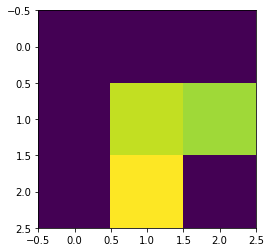

In [75]:
shape = gdf_8m.iloc[0,-1]
col_names = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12","CLM"]
path='/Users/mikhailgasanov/Yandex.Disk.localized/STRIP/Bratsk/Sentinel2_2019_10_meters/'
year = 2019
list_of_geotiff = [tiff for tiff in os.listdir(path) if (str('-') in tiff) and ('tiff' in tiff)]

df_indices_field = pd.DataFrame(columns = ['date',  *col_names, "NDVI"])

dates_of_images = []



for tiff_file in sorted(list_of_geotiff):
    path_to_tiff_file = os.path.join(path, tiff_file)
    with rio.open(path_to_tiff_file) as src:
        out_image, out_transform = crop_mask(src, [shape], crop=True) # SUPER KEK - [shape] works, shape - doesn't
        out_meta = src.meta 
        x = out_image[:12, ...].reshape(12, out_image.shape[1]*out_image.shape[2])
    _df = pd.DataFrame(x.T, columns=col_names[:-1])
#     df

plt.imshow(out_image[3,...])

In [16]:
gdf_8m.crs

<Derived Projected CRS: EPSG:32647>
Name: WGS 84 / UTM zone 47N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 96°E and 102°E, northern hemisphere between equator and 84°N, onshore and offshore. China. Indonesia. Laos. Malaysia - West Malaysia. Mongolia. Myanmar (Burma). Russian Federation. Thailand.
- bounds: (96.0, 0.0, 102.0, 84.0)
Coordinate Operation:
- name: UTM zone 47N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## * Clusters

In [187]:
from sklearn.cluster import DBSCAN

In [189]:
fnames = {"invent_plots":"../shape_data/dataset_plots.geojson"}
gdf = gpd.read_file(fnames['invent_plots'])
gdf.loc[:, 'key'] = gdf.index
gdf=procces_gdf(gdf)
dataset = Dataset(tiff_fname=None, scale=1)
bands, terrain = dataset.prepare_forest_classes_dataset(gdf=gdf)
col_2020 = [col for col in bands.columns if '2019' not in col]
df = pd.concat([bands[col_2020[:-2]], terrain], axis=1)
df = df.copy()
df[['aspect','slope','wetnessindex','sink']] = df[['aspect','slope','wetnessindex','sink']].astype(float)
forest = df["class"] < 20
df_resampled = df.loc[forest]
_X = df_resampled.iloc[:, :-2]
scaled = StandardScaler().fit_transform(_X)
df_resampled.iloc[:, :-2] = scaled

8.974945806042294
Start bands . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Start terrain . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [204]:
df= df_resampled.loc[df_resampled['class'] < 8]

In [205]:
X = df.iloc[:, :-2].values
labels_true = df['class'].values

In [207]:
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
# print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 0
Estimated number of noise points: 1552
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000


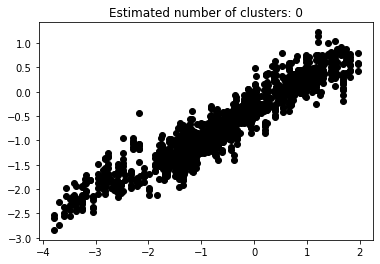

In [208]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [209]:
from sklearn.manifold import TSNE

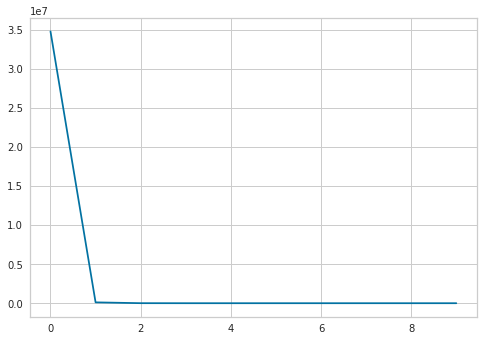

In [24]:
plt.plot(x)

In [285]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1552 samples in 0.002s...
[t-SNE] Computed neighbors for 1552 samples in 0.760s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1552
[t-SNE] Computed conditional probabilities for sample 1552 / 1552
[t-SNE] Mean sigma: 1.522654
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.012894
[t-SNE] KL divergence after 1000 iterations: 0.420003


[Text(0.5, 1.0, 'Iris data T-SNE projection')]

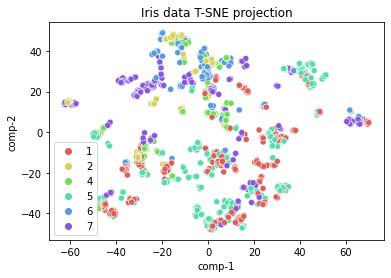

In [286]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(X)
df = pd.DataFrame()
df["y"] = labels_true
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 7),
                data=df).set(title="Iris data T-SNE projection")

In [284]:
df_resampled

,2020-07-03_B01,2020-07-03_B02,2020-07-03_B03,2020-07-03_B04,2020-07-03_B05,2020-07-03_B06,2020-07-03_B07,2020-07-03_B08,2020-07-03_B8A,2020-07-03_B09,...,2020-08-17_NDVI,2020-08-17_EVI,2020-08-17_MSAVI,2020-08-17_NDRE,aspect,slope,wetnessindex,sink,key,class
1,1.792429,1.348706,0.330713,0.312257,-0.095310,-0.253746,-0.268301,-0.281320,-0.242449,0.571983,...,0.371992,-0.074120,-0.127335,0.229506,1.367919,0.953838,0.910102,0.923583,0,7
2,1.792429,1.016141,0.385859,0.126729,-0.201537,0.000807,0.201008,-0.243810,0.060850,0.571983,...,0.329715,-0.104955,-0.158971,0.439258,1.408838,1.133018,0.910102,0.975758,0,7
3,1.792429,1.282193,0.291323,0.103538,-0.201537,0.000807,0.201008,-0.308327,0.060850,0.571983,...,0.282231,-0.190107,-0.247549,0.384072,1.436118,1.312197,0.910102,0.975758,0,7
4,1.792429,1.109259,0.165276,0.219493,-0.181865,0.016499,0.127631,-0.153785,0.071360,0.571983,...,0.371786,-0.007890,-0.056854,0.825016,1.463398,1.670557,0.910102,1.030659,0,7
5,1.792429,1.082654,-0.023796,0.003044,-0.181865,0.016499,0.127631,-0.486875,0.071360,0.571983,...,0.409103,-0.239694,-0.303155,0.611763,1.613438,1.670557,0.910102,1.030659,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,-0.009217,-0.141186,0.236177,0.057156,0.018786,-0.288617,-0.398239,-0.416356,-0.365571,-0.310101,...,-0.300856,-0.863239,-0.918285,-0.964674,-2.683160,0.057938,1.164150,1.083686,287,15
5,-0.009217,0.257893,0.385859,0.374099,0.018786,-0.288617,-0.398239,-0.272317,-0.365571,-0.310101,...,-0.323759,-0.735622,-0.788625,-0.749044,-1.455560,0.057938,1.164150,0.943686,287,15
6,-0.009217,-0.034765,0.015594,-0.035608,-0.020558,-0.332204,-0.538879,-0.378846,-0.421125,-0.310101,...,-0.290550,-0.672576,-0.725979,-0.790179,0.385839,-0.300422,-0.868234,1.083686,287,15
7,-0.009217,-0.300817,0.165276,-0.020147,0.065998,-0.271181,-0.523592,-0.512382,-0.364069,-0.310101,...,-0.198935,-0.677727,-0.734866,-0.824091,-2.069360,0.237118,1.164150,1.083686,287,15


In [18]:
x = [34773627.69,
108809.4629,
4328.761281,
15.91542285,
6.830975986,
10,
2.947051703,
28.22956756,
2.041737945,
1]

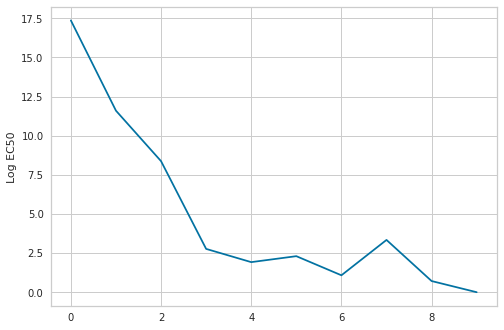

In [27]:
plt.plot(np.log(x))
plt.ylabel('Log EC50')
plt.show()

In [1]:
import rasterio as rio


In [7]:
fname = '../rasters/bands_and_terrain.tiff'
with rio.open(fname, 'r+') as src: 
    x1 = src.read(1)
    print(x1.shape)

    x11 = src.read(11)
    print(x11.shape)
#     print(src.shape)

(3461, 3159)
(3461, 3159)


In [4]:
import matplotlib.pyplot as plt

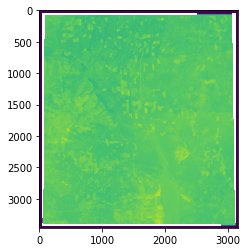

In [5]:
plt.imshow(x)

In [6]:
src.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 3159,
 'height': 3461,
 'count': 20,
 'crs': CRS.from_epsg(32647),
 'transform': Affine(10.0, 0.0, 652275.7556,
        0.0, -10.0, 6306481.6333)}